In [1]:
import tensorflow as tf
from tensorflow import keras
import resnet
import matplotlib.pyplot as plt

In [2]:
input_size = 224
batch_size = 32

lr = 0.0001

ae = resnet.Autoencoder()

In [3]:
def scaling(x):
    x = tf.cast(x, tf.float32) / 255.
    return x

In [4]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    './DOG',
    image_size=(input_size, input_size),
    batch_size=batch_size,
    label_mode=None,
    validation_split=0.01,
    subset='training',
    seed=42)

test_ds = keras.preprocessing.image_dataset_from_directory(
    './DOG',
    image_size=(input_size, input_size),
    batch_size=batch_size,
    label_mode=None,
    validation_split=0.01,
    subset='validation',
    seed=42)

train_ds = train_ds.map(scaling).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(scaling).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 15348 files belonging to 157 classes.
Using 15195 files for training.
Found 15348 files belonging to 157 classes.
Using 153 files for validation.


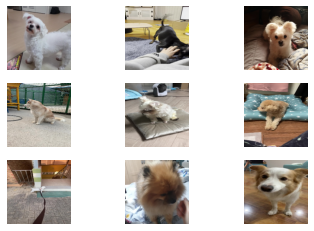

In [5]:
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')

In [6]:
mse = keras.losses.MeanSquaredError()

@tf.function
def train_step(x, model, optimizer):
    with tf.GradientTape() as tape:
        recon = model(x)
        loss = mse(x, recon)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
optimizer = keras.optimizers.Adam(lr)
epochs =100

for epoch in range(1, epochs + 1):
    for train_x in train_ds:
        train_step(train_x, ae, optimizer)
        
    loss = tf.keras.metrics.Mean()
    
    for test_x in test_ds:
        test_recon = ae(test_x)
        loss(mse(test_x, test_recon))
    print(loss.result())

Tensor("mean_squared_error/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("mean_squared_error/weighted_loss/value:0", shape=(), dtype=float32)
